### Data Modeling 

In [54]:
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

## Time Series Task #1

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if neededs
     - Use `interpolate()` or `fillna()` for missing values

In [55]:
# load dataset and create series 
df = pd.read_csv("patient_longitudinal.csv", sep='\t')
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [56]:
# handle duplicates 
df = df.groupby(['patient_id', 'visit_date']).mean().reset_index()

# make visit_date a datetimeindex
df.set_index('visit_date', inplace=True)

# missing values
df['bp_systolic'] = df['bp_systolic'].interpolate() 

#print(data.head)

## Time Series Task #2

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

/tmp/ipykernel_2110/2663168932.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthFreq = df['bp_systolic'].resample('M').mean()


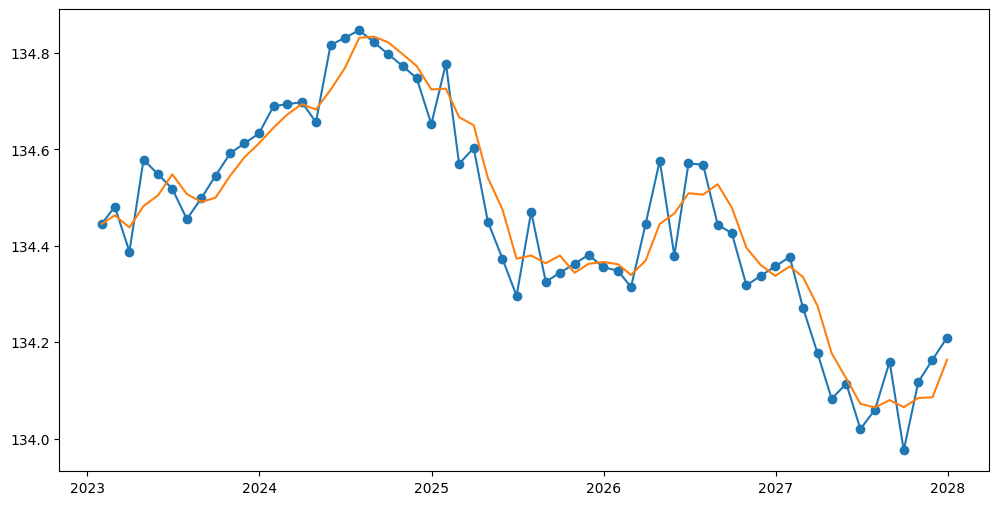

In [57]:
# resample monthly frequency 
monthFreq = df['bp_systolic'].resample('M').mean() 

# handle missing values
monthFreq = monthFreq.interpolate()

# 3 month moving averages 
movingAvg3 = monthFreq.rolling(window = 3, min_periods = 1).mean() 

# visualization of original and smoothed trends
plt.figure(figsize = (12,6))
plt.plot(monthFreq, label = 'Original Blood Pressure Monthly Trend', marker = 'o')
plt.plot(movingAvg3, label = '3 Month Moving Average Trend', linestyle = '-')  

## Interpretation: 
From this visualization we can see that the monthly average for blood pressure was a lot more erratic that the 3 month moving average. But they both follow generally the same trends acrossa ll the years. 

## Statistical Modeling Task #1

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        00:31:21   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

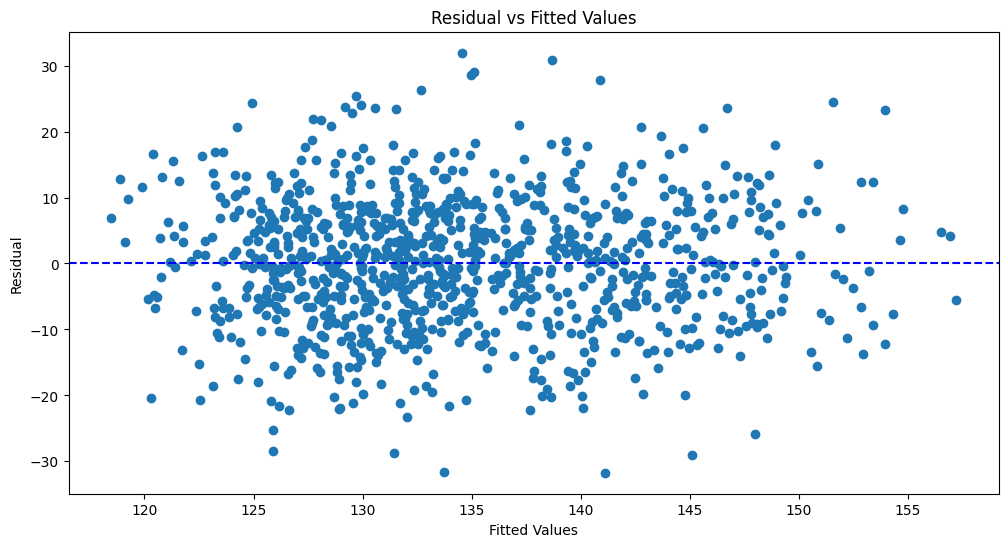

<Figure size 1200x600 with 0 Axes>

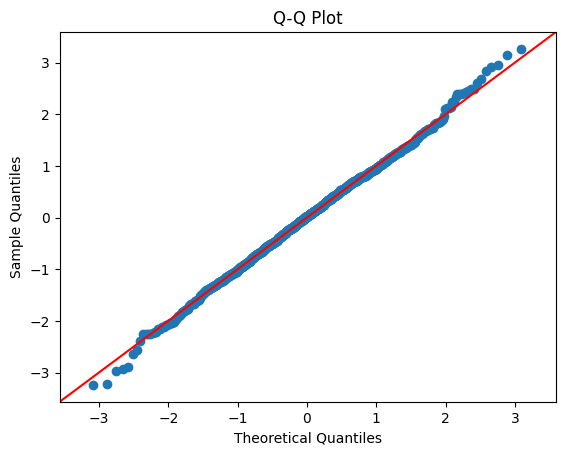

In [58]:
df = pd.read_csv("patient_baseline.csv", sep='\t')

y = df['bp_systolic'] # variable we are measuring
X = df[['age', 'bmi', 'smoking', 'diabetes']] # feature matrix 
X = sm.add_constant(X) # constant term 

model = sm.OLS(y, X).fit(cov_type = 'HC3') # fit the model 
print(model.summary()) # print model summary 

# plot residuals vs fitted values 
plt.figure(figsize = (12,6))

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual vs Fitted Values')
plt.show()

# Q-Q plot 
plt.figure(figsize = (12,6))
sm.qqplot(model.resid, line = '45', fit = True)
plt.title('Q-Q Plot')
plt.show()

## Interpretation:
Ideally, residuals should be randomly scattered without a clear pattern which is what the scatter plot depicts, meaning that the model is accurately capturing the relationship between fitted and residual values. In the Q-Q plot, most of the points lie on the red line which shows that the residuals are normally distributed. 

## Statistical Modeling Task #2

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Thu, 07 Nov 2024   Deviance:                       1312.8
Time:                        00:31:26   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

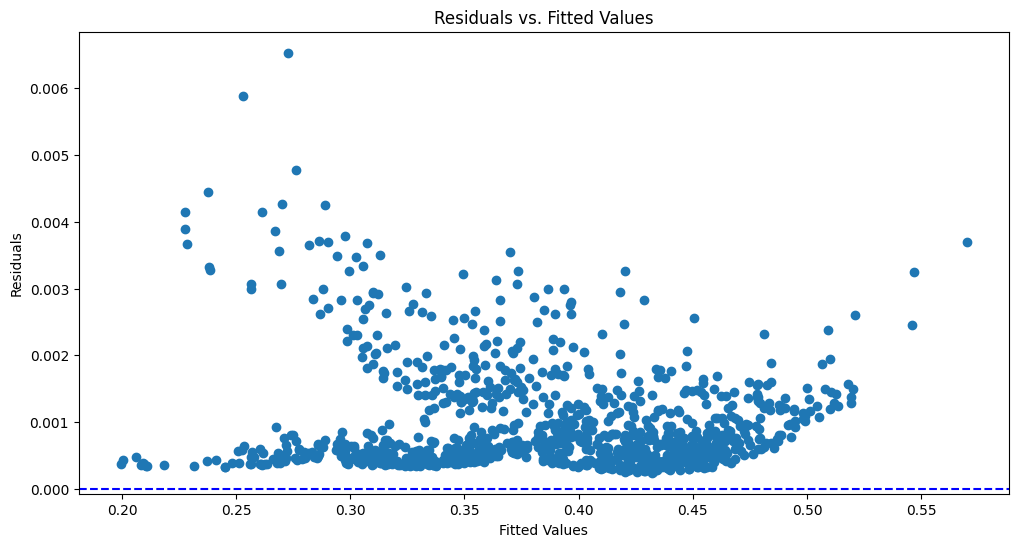

In [59]:
df = pd.read_csv("patient_treatment.csv", sep='\t') 

y = df['outcome'] #set treatment outcome/success as dependent variable
X = df[['age', 'bmi', 'smoking','diabetes', 'adherence']] #set predictors 
X = sm.add_constant(X) 

model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

# Calculate odds ratios and 95% confidence intervals
oddsRatio = np.exp(model.params)
confidenceInts = np.exp(model.conf_int())
oddsRatiosDF = pd.DataFrame({'Odds Ratio': oddsRatio,'2.5%': confidenceInts[0],'97.5%': confidenceInts[1]
})
print("\nOdds Ratios and 95% Confidence Intervals:")
print(oddsRatiosDF)

# null and residual deviance
nullDev = model.null_deviance
residDev = model.deviance

print(f'Null Deviance: {nullDev}')
print(f'Residual Deviance: {residDev}')

# plot for influential observations 
influenceObs = model.get_influence()
cooks = influenceObs.cooks_distance[0] 

# plot
plt.figure(figsize = (12,6))

plt.scatter(model.fittedvalues, cooks) 
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()



## Interpretation 
Because of the funnel shaped pattern of the fitted values, this indicates heteroscedasticity, which means the variance of the residuals is not constant across the range of fitted values. Most of the points are also close to 0.000 meaning the mode is not under or over predicting across the range of fitted values. 